#Pyspark Machine Learning



In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install pyspark

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 317.0/317.0 MB 2.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.5.1-py2.py3-none-any.whl size=317488491 sha256=6978cbb9c2ed45d69ac94dc8610b9ec971335a79eaa8775940315b14de2bd4a2
  Stored in directory: /root/.cache/pip/wheels/80/1d/60/2c256ed38dddce2fdd93be545214a63e02fbd8d74fb0b7f3a6
Successfully built pyspark


In [21]:
import numpy as np
import os
from pyspark.sql import SparkSession
from pyspark.sql.types import *
from pyspark.ml.linalg import Vectors, VectorUDT
from pyspark.ml.feature import BucketedRandomProjectionLSH

# Init SparkSession
spark = SparkSession.builder.appName("Pyspark Tutorial") \
.config("spark.sql.legacy.timeParserPolicy", "LEGACY") \
.getOrCreate()
df = spark.read.csv('/content/drive/MyDrive/Python/data/OnlineRetail.csv',header=True)
df.printSchema()
df.show(5)

# spark.stop()


root
 |-- InvoiceNo: string (nullable = true)
 |-- StockCode: string (nullable = true)
 |-- Description: string (nullable = true)
 |-- Quantity: string (nullable = true)
 |-- InvoiceDate: string (nullable = true)
 |-- UnitPrice: string (nullable = true)
 |-- CustomerID: string (nullable = true)
 |-- Country: string (nullable = true)

+---------+---------+--------------------+--------+----------------+---------+----------+--------------+
|InvoiceNo|StockCode|         Description|Quantity|     InvoiceDate|UnitPrice|CustomerID|       Country|
+---------+---------+--------------------+--------+----------------+---------+----------+--------------+
|   536365|   85123A|WHITE HANGING HEA...|       6|01-12-2010 08:26|     2.55|     17850|United Kingdom|
|   536365|    71053| WHITE METAL LANTERN|       6|01-12-2010 08:26|     3.39|     17850|United Kingdom|
|   536365|   84406B|CREAM CUPID HEART...|       8|01-12-2010 08:26|     2.75|     17850|United Kingdom|
|   536365|   84029G|KNITTED UNION

In [36]:
from pyspark.sql.functions import to_timestamp

# Định dạng lại trường dữ liệu ngày tháng thành timestamp để có thể sort, tìm min hoặc max
df = df.withColumn("date", to_timestamp("InvoiceDate", "dd-MM-yy HH:mm"))


In [41]:
from pyspark.sql.functions import max

# Ngày có đơn hàng gần đây nhất
most_recent_date = df.select(max("date")).collect()[0][0]
print("Ngày có đơn hàng gần đây nhất:", most_recent_date)


Ngày có đơn hàng gần đây nhất: 2011-12-09 12:50:00


In [32]:
df.printSchema()
df.select("date").show(5)

root
 |-- InvoiceNo: string (nullable = true)
 |-- StockCode: string (nullable = true)
 |-- Description: string (nullable = true)
 |-- Quantity: string (nullable = true)
 |-- InvoiceDate: string (nullable = true)
 |-- UnitPrice: string (nullable = true)
 |-- CustomerID: string (nullable = true)
 |-- Country: string (nullable = true)
 |-- date: timestamp (nullable = true)
 |-- from_date: timestamp (nullable = true)

+-------------------+
|               date|
+-------------------+
|2010-12-01 08:26:00|
|2010-12-01 08:26:00|
|2010-12-01 08:26:00|
|2010-12-01 08:26:00|
|2010-12-01 08:26:00|
+-------------------+
only showing top 5 rows



In [26]:
from pyspark.sql.functions import lit
df = df.withColumn("from_date", lit("2010-12-01 08:26:00"))


In [33]:
# from pyspark.sql.functions import col
# df = df.withColumn('from_date',to_timestamp("from_date", 'yy-MM-dd HH:mm'))
# df2 = df.withColumn('from_date',to_timestamp(col('from_date'))).withColumn('recency',col("InvoiceDate").cast("long") - col('from_date').cast("long"))


## Recency

In [45]:
from pyspark.sql.functions import col, to_timestamp, count

# Chuyển đổi cột "from_date" thành dấu thời gian (timestamp)
df = df.withColumn('from_date', to_timestamp("from_date", 'yy-MM-dd HH:mm'))

# Tính toán cột "recency" bằng cách tính sự chênh lệch giữa hai timestamps
df2 = df.withColumn('from_date', to_timestamp(col('from_date'))) \
         .withColumn('recency', col("date").cast("long") - col('from_date').cast("long"))

# Hiển thị các dòng đầu tiên của DataFrame df2
df2.show()


+---------+---------+--------------------+--------+----------------+---------+----------+--------------+-------------------+-------------------+-------+
|InvoiceNo|StockCode|         Description|Quantity|     InvoiceDate|UnitPrice|CustomerID|       Country|               date|          from_date|recency|
+---------+---------+--------------------+--------+----------------+---------+----------+--------------+-------------------+-------------------+-------+
|   536365|   85123A|WHITE HANGING HEA...|       6|01-12-2010 08:26|     2.55|     17850|United Kingdom|2010-12-01 08:26:00|2010-12-01 08:26:00|      0|
|   536365|    71053| WHITE METAL LANTERN|       6|01-12-2010 08:26|     3.39|     17850|United Kingdom|2010-12-01 08:26:00|2010-12-01 08:26:00|      0|
|   536365|   84406B|CREAM CUPID HEART...|       8|01-12-2010 08:26|     2.75|     17850|United Kingdom|2010-12-01 08:26:00|2010-12-01 08:26:00|      0|
|   536365|   84029G|KNITTED UNION FLA...|       6|01-12-2010 08:26|     3.39|    

In [43]:
df2 = df2.join(df2.groupBy('CustomerID').agg(max('recency').alias('recency')),on='recency',how='leftsemi')


## Frequency

In [46]:
df_freq = df2.groupBy('CustomerID').agg(count('InvoiceNo').alias('frequency'))


In [47]:
df_freq.show()

+----------+---------+
|CustomerID|frequency|
+----------+---------+
|     16250|       24|
|     15574|      168|
|     15555|      925|
|     15271|      275|
|     17714|       10|
|     17686|      286|
|     13865|       30|
|     14157|       49|
|     13610|      228|
|     13772|      177|
|     13282|       40|
|     12394|       27|
|     16320|       56|
|     13192|       63|
|     17757|      742|
|     17551|       43|
|     13187|       37|
|     16549|      981|
|     12637|      394|
|     15052|       30|
+----------+---------+
only showing top 20 rows



In [48]:
df3 = df2.join(df_freq,on='CustomerID',how='inner')

## Monetary

In [49]:
m_val = df3.withColumn('TotalAmount',col("Quantity") * col("UnitPrice"))


In [51]:
m_val.show()

+----------+---------+---------+--------------------+--------+----------------+---------+--------------+-------------------+-------------------+-------+---------+------------------+
|CustomerID|InvoiceNo|StockCode|         Description|Quantity|     InvoiceDate|UnitPrice|       Country|               date|          from_date|recency|frequency|       TotalAmount|
+----------+---------+---------+--------------------+--------+----------------+---------+--------------+-------------------+-------------------+-------+---------+------------------+
|     17850|   536365|   85123A|WHITE HANGING HEA...|       6|01-12-2010 08:26|     2.55|United Kingdom|2010-12-01 08:26:00|2010-12-01 08:26:00|      0|      312|15.299999999999999|
|     17850|   536365|    71053| WHITE METAL LANTERN|       6|01-12-2010 08:26|     3.39|United Kingdom|2010-12-01 08:26:00|2010-12-01 08:26:00|      0|      312|             20.34|
|     17850|   536365|   84406B|CREAM CUPID HEART...|       8|01-12-2010 08:26|     2.75|U

In [53]:
m_val.printSchema()

root
 |-- CustomerID: string (nullable = true)
 |-- InvoiceNo: string (nullable = true)
 |-- StockCode: string (nullable = true)
 |-- Description: string (nullable = true)
 |-- Quantity: string (nullable = true)
 |-- InvoiceDate: string (nullable = true)
 |-- UnitPrice: string (nullable = true)
 |-- Country: string (nullable = true)
 |-- date: timestamp (nullable = true)
 |-- from_date: timestamp (nullable = true)
 |-- recency: long (nullable = true)
 |-- frequency: long (nullable = false)
 |-- TotalAmount: double (nullable = true)



In [56]:
m_val = m_val.groupBy('CustomerID').agg(sum('TotalAmount').alias('monetary_value'))


In [57]:
m_val.show()

+----------+------------------+
|CustomerID|    monetary_value|
+----------+------------------+
|     16250|389.44000000000005|
|     15574| 702.2500000000001|
|     15555| 4758.199999999993|
|     15271|2485.8199999999997|
|     17714|             153.0|
|     17686| 5739.460000000005|
|     13865|501.56000000000006|
|     14157| 400.4300000000001|
|     13610|1115.4299999999998|
|     13772|           1132.13|
|     13282|           1047.84|
|     12394|           1272.48|
|     16320|           1038.46|
|     13192|            911.94|
|     17757| 5585.489999999997|
|     17551|            306.84|
|     13187|236.01999999999995|
|     16549| 4154.640000000004|
|     12637| 5953.250000000002|
|     15052|            215.78|
+----------+------------------+
only showing top 20 rows



In [58]:
final_df = m_val.join(df3,on='CustomerID',how='inner')


In [59]:
final_df = final_df.select(['recency','frequency','monetary_value','CustomerID']).distinct()


In [71]:
# df_filter = df.select("*").filter(~col("InvoiceNo").startswith("C"))
# # check xem số lượng dữ liệu còn bao nhiêu
# df_filter.count()   # 532621
# df_filter.select('CustomerID').distinct().count()  # 4340


4340

## Normalization data

In [ ]:
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.feature import StandardScaler

assemble=VectorAssembler(inputCols=[
    'recency','frequency','monetary_value'
], outputCol='features')

assembled_data=assemble.transform(final_df)

scale=StandardScaler(inputCol='features',outputCol='standardized')
data_scale=scale.fit(assembled_data)
data_scale_output=data_scale.transform(assembled_data)


In [61]:
data_scale_output.select('standardized').show(2,truncate=True)

+--------------------+
|        standardized|
+--------------------+
|[5.72872573800991...|
|[0.01158064987898...|
+--------------------+
only showing top 2 rows



## Machine Leanring with Kmeans

In [62]:
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator
import numpy as np

cost = np.zeros(10)
evaluator = ClusteringEvaluator(predictionCol='prediction', featuresCol='standardized',metricName='silhouette', distanceMeasure='squaredEuclidean')

for i in range(2,10):
    KMeans_algo=KMeans(featuresCol='standardized', k=i)
    KMeans_fit=KMeans_algo.fit(data_scale_output)
    output=KMeans_fit.transform(data_scale_output)
    cost[i] = KMeans_fit.summary.trainingCost


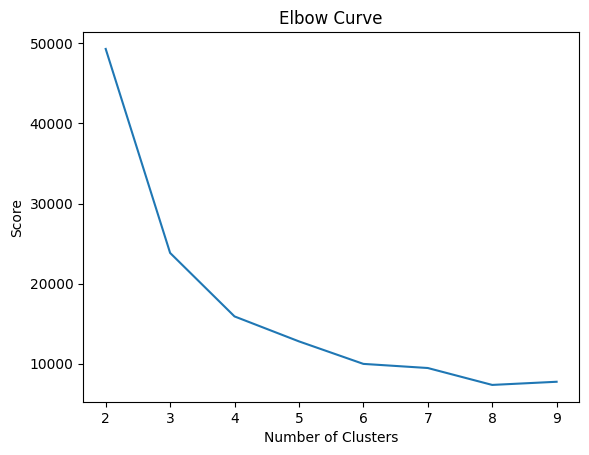

In [63]:
import pandas as pd
import pylab as pl
df_cost = pd.DataFrame(cost[2:])
df_cost.columns = ["cost"]
new_col = range(2,10)
df_cost.insert(0, 'cluster', new_col)
pl.plot(df_cost.cluster, df_cost.cost)
pl.xlabel('Number of Clusters')
pl.ylabel('Score')
pl.title('Elbow Curve')
pl.show()


## Triển khai với số cụm bằng 3

In [75]:
kmeans_algo=KMeans(featuresCol='standardized', k=3)
kmeans_fit=kmeans_algo.fit(data_scale_output)


In [76]:
preds=kmeans_fit.transform(data_scale_output)
preds.show(5)


+-------+---------+------------------+----------+--------------------+--------------------+----------+
|recency|frequency|    monetary_value|CustomerID|            features|        standardized|prediction|
+-------+---------+------------------+----------+--------------------+--------------------+----------+
|   5580|       24|389.44000000000005|     16250|[5580.0,24.0,389....|[5.72872573800991...|         1|
| 112800|      168| 702.2500000000001|     15574|[112800.0,168.0,7...|[0.01158064987898...|         1|
| 368340|      925| 4758.199999999993|     15555|[368340.0,925.0,4...|[0.03781574979101...|         1|
| 710460|      275|2485.8199999999997|     15271|[710460.0,275.0,2...|[0.07293961447717...|         1|
| 721620|      925| 4758.199999999993|     15555|[721620.0,925.0,4...|[0.07408535962477...|         1|
+-------+---------+------------------+----------+--------------------+--------------------+----------+
only showing top 5 rows



## Data Visualization

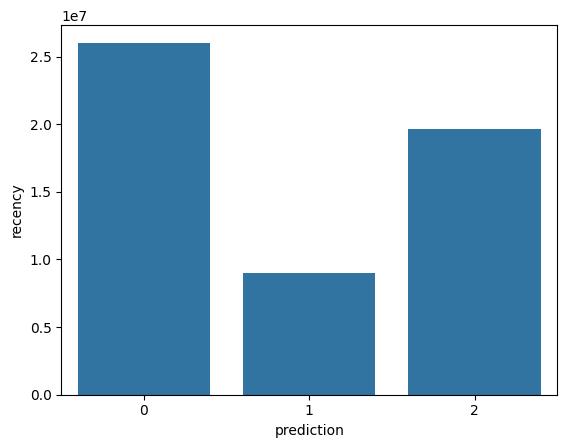

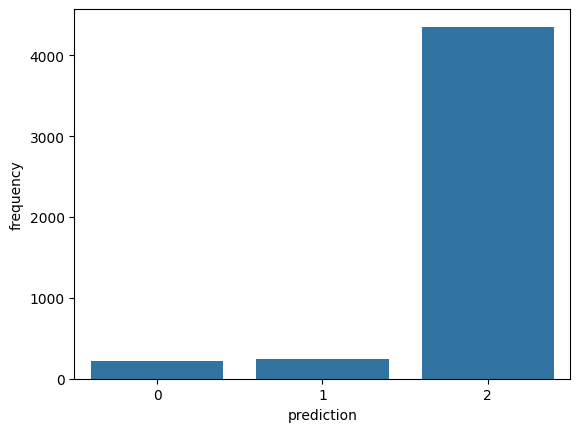

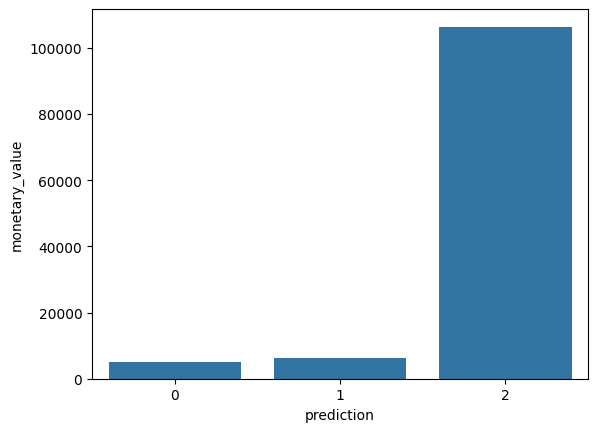

In [77]:
import matplotlib.pyplot as plt
import seaborn as sns

df_viz = preds.select('recency','frequency','monetary_value','prediction')
df_viz = df_viz.toPandas()
avg_df = df_viz.groupby(['prediction'], as_index=False).mean()

list1 = ['recency','frequency','monetary_value']

for i in list1:
    sns.barplot(x='prediction',y=str(i),data=avg_df)
    plt.show()


### Kết quả:
Nhóm 0: Nhóm này có tần suất mua hàng tương đối cao, cao trội hơn 3 nhóm còn lại, lần truy cập gần nhất tương đối thấp, giá trị tiền mua hàng tương đối nhỏ, cho thấy là một đối tượng đa số là cá nhân, hướng tới các sản phẩm giá rẻ

Nhóm 1: Nhóm này có cả 3 chỉ số lần truy cập gần nhất, tấn suất mua hàng và tổng tiền mua hàng rất thấp, không có quá nhiều hi vọng là khách hàng tiềm năng, khả năng cao sẽ ngừng mua hàng trong thời gian tới

Nhóm 2: Thời gian mua hàng gần nhất thấp hơn nhóm 1, tần suất đặt hàng rất cao, lượng tiền mua hàng cao vượt trội nhiều lần so với các nhóm khác. Nhóm này khả năng là các doanh nghiệp có xu hướng mua các loại hàng có giá trị cao hoặc mua có số lượng lớn
